In [125]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [126]:
import yfinance as yf
class SimpleMovingAverageBT():
    def __init__(self, symbol, sma_s, sma_l, start, end):
        self.symbol = symbol
        self.sma_s = sma_s
        self.sma_l = sma_l
        self.start = start
        self.end = end
        self.get_data()
        self.process_data()
    
    def __repr__(self):
        return "SimpleMovingAverageBT: {}, Short window = {}, Long window = {}".format(self.symbol, self.sma_s, self.sma_l)
    def get_data(self):
        '''
            Loads the stock data from the yfinance library
        '''
        df = yf.download(self.symbol, self.start, self.end)
        df = df.Close.to_frame() #we will work with close prices only
        df.rename(columns = {"Close":"Price"}, inplace = True) 
        self.data = df
    def process_data(self):
        '''
            Calculates important metrics like returns,rolling averages etc. for further analysis
        '''
        df = self.data.copy() #always make a copy first to prevent overriding data before calculations
        df["returns"] = np.log(df.Price/df.Price.shift(1))
        df["SMA_S"] = df.Price.rolling(self.sma_s).mean()
        df["SMA_L"] = df.Price.rolling(self.sma_l).mean()
        self.data = df
    def set_window(self, sma_s = None, sma_l = None):
        if sma_s != None:
            self.sma_s = sma_s
        if sma_l != None:
            self.sma_l = sma_l
        self.get_data()
        self.process_data()
        
    def backtest(self):
        df = self.data.copy().dropna()
        df["positions"] = np.where(df.SMA_S>df.SMA_L, 1, -1)
        df["r_strategy"] = df.positions.shift(1) * df.returns
        df.dropna(inplace = True)
        df["creturns"] = df.returns.cumsum().apply(np.exp) #convert the log returns
        df["cr_strategy"] = df.r_strategy.cumsum().apply(np.exp)
        self.result = df
        strategy_perf = round(df.cr_strategy.iloc[-1],4)
        strategy_outperf = round(df.cr_strategy.iloc[-1] - df.creturns.iloc[-1], 4)
        print(f"SMA absolute performance: {strategy_perf} || SMA outperformance vs Buy and Hold: {strategy_outperf}" )
    def plot_data(self):
        if self.result is None:
            raise Exception("Run Backtest first, no results to plot!")
        self.result[["creturns","cr_strategy"]].plot(figsize = (12,8), fontsize = 13)
        plt.title(f"{self.symbol} || SMA(short) = {self.sma_s} || SMA(Long) = {self.sma_l}", size = 20)
        plt.legend(fontsize = 13)
        plt.show()
    # TODO
    def optimise_windows(self, sma_s_range, sma_l_range):
        #find optimal short and long term window combination based on a given input range
        pass

    

In [127]:
tester = SimpleMovingAverageBT("EURUSD=X", 50, 200, "2004-01-01", "2020-07-01")

[*********************100%%**********************]  1 of 1 completed


In [128]:
tester.data

,Price,returns,SMA_S,SMA_L
Date,,,,
2004-01-01,1.258194,NaN,NaN,NaN
2004-01-02,1.258194,0.000000,NaN,NaN
2004-01-05,1.268698,0.008313,NaN,NaN
2004-01-06,1.272103,0.002681,NaN,NaN
2004-01-07,1.264095,-0.006315,NaN,NaN
...,...,...,...,...
2020-06-24,1.131235,0.002892,1.101794,1.103430
2020-06-25,1.125087,-0.005449,1.102486,1.103540
2020-06-26,1.122208,-0.002562,1.103213,1.103627


In [129]:
tester.backtest()

SMA absolute performance: 1.2835 || SMA outperformance vs Buy and Hold: 0.3677


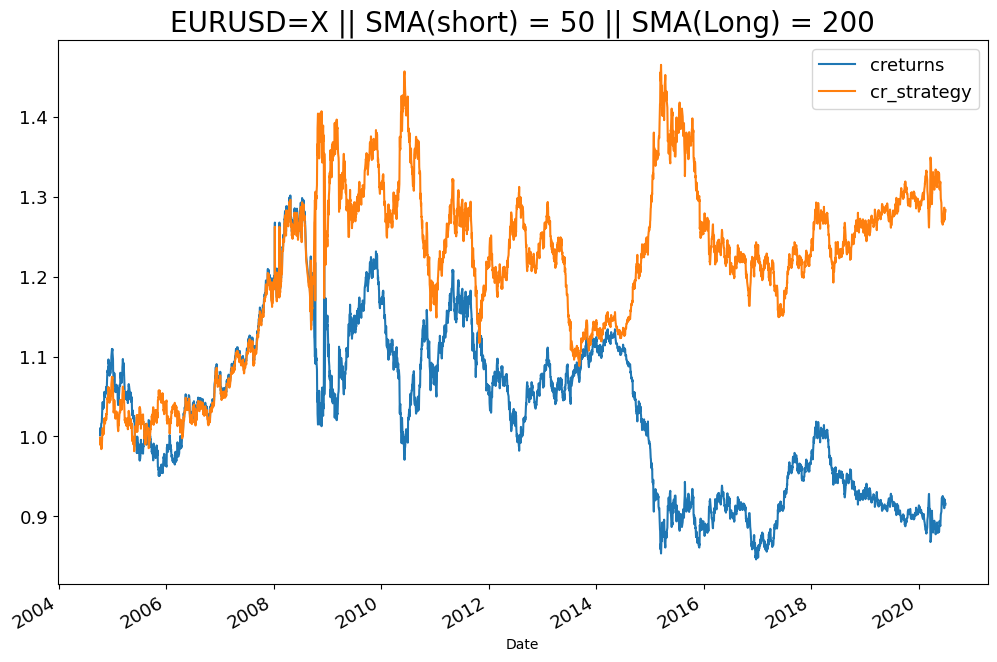

In [130]:
tester.plot_data()

In [131]:
tester.set_window(36,174)

[*********************100%%**********************]  1 of 1 completed


In [132]:
tester.backtest()

SMA absolute performance: 1.8911 || SMA outperformance vs Buy and Hold: 0.9675


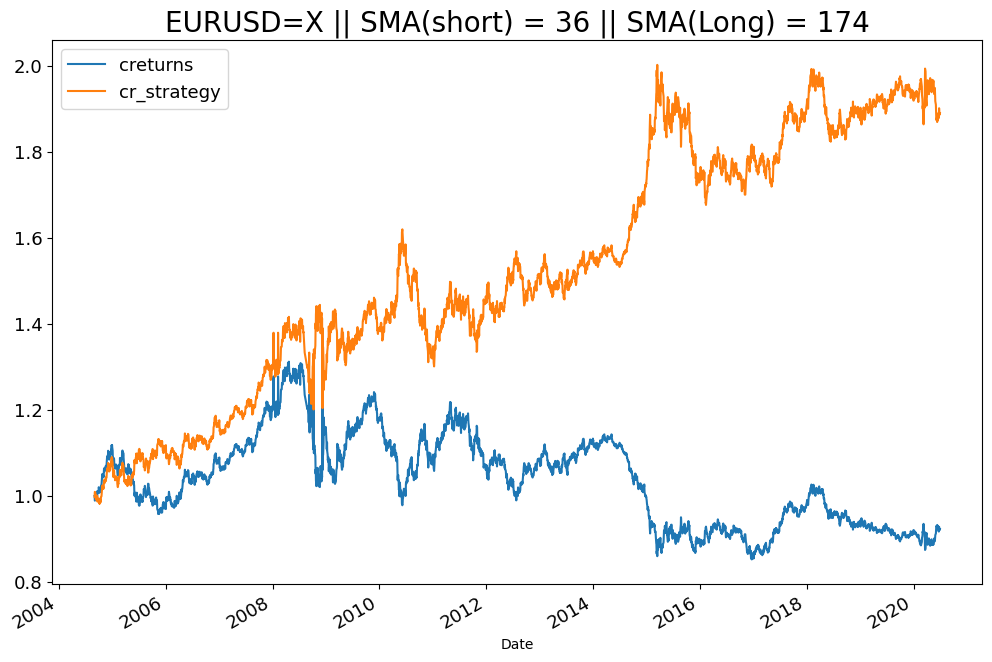

In [133]:
tester.plot_data()

In [134]:
tester.result

,Price,returns,SMA_S,SMA_L,positions,r_strategy,creturns,cr_strategy
Date,,,,,,,,
2004-09-01,1.219007,0.000987,1.220339,1.226260,-1,-0.000987,1.000987,0.999014
2004-09-02,1.217300,-0.001401,1.219750,1.226025,-1,0.001401,0.999586,1.000414
2004-09-03,1.205502,-0.009740,1.218914,1.225662,-1,0.009740,0.989898,1.010205
2004-09-06,1.206593,0.000905,1.217830,1.225285,-1,-0.000905,0.990794,1.009292
2004-09-07,1.209907,0.002743,1.216883,1.224974,-1,-0.002743,0.993515,1.006527
...,...,...,...,...,...,...,...,...
2020-06-24,1.131235,0.002892,1.107741,1.103664,1,0.002892,0.928913,1.902059
2020-06-25,1.125087,-0.005449,1.108886,1.103749,1,-0.005449,0.923865,1.891723
2020-06-26,1.122208,-0.002562,1.110063,1.103828,1,-0.002562,0.921501,1.886883


In [135]:
tester.data

,Price,returns,SMA_S,SMA_L
Date,,,,
2004-01-01,1.258194,NaN,NaN,NaN
2004-01-02,1.258194,0.000000,NaN,NaN
2004-01-05,1.268698,0.008313,NaN,NaN
2004-01-06,1.272103,0.002681,NaN,NaN
2004-01-07,1.264095,-0.006315,NaN,NaN
...,...,...,...,...
2020-06-24,1.131235,0.002892,1.107741,1.103664
2020-06-25,1.125087,-0.005449,1.108886,1.103749
2020-06-26,1.122208,-0.002562,1.110063,1.103828


In [136]:
print(tester)

SimpleMovingAverageBT: EURUSD=X, Short window = 36, Long window = 174
